In [1]:
# 📦 Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 🌱 Aesthetics
sns.set(style="whitegrid", context="notebook")
sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(8, 8))


In [2]:
# 🚀 Load scFoundation original single-cell embeddings
embeddings = np.load("../../data/embeddings/scfoundation/pancancer_embeddings.npy")
print("✅ Embeddings shape:", embeddings.shape)

# 📋 Load matching single-cell metadata
adata = sc.read("../../data/processed/pancancer_dimred.h5ad")


✅ Embeddings shape: (39715, 3072)


In [7]:
# 🩺 Load tissue dummy matrix and map tissues
tissue_df = pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")
tissue_cols = [col for col in tissue_df.columns if col.startswith("Tissue_")]
tissue_df["Tissue"] = tissue_df[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "")
tissue_map = tissue_df.set_index("SANGER_MODEL_ID")["Tissue"]


In [8]:
# 🔗 Construct metadata DataFrame
metadata_df = adata.obs.reset_index().rename(columns={"index": "CELL_ID"})
metadata_df["Tissue"] = metadata_df["SIDM"].map(tissue_map)

# ✅ Ensure alignment
assert embeddings.shape[0] == metadata_df.shape[0], "Mismatch between embeddings and metadata rows."
print("✅ Metadata shape:", metadata_df.shape)


✅ Metadata shape: (39715, 7)


In [9]:
'''
# 📊 Standardize and compute t-SNE
X_emb = StandardScaler().fit_transform(embeddings)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(X_emb)

metadata_df["TSNE_1"] = tsne_coords[:, 0]
metadata_df["TSNE_2"] = tsne_coords[:, 1]

# 🎨 t-SNE plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=metadata_df,
    x="TSNE_1",
    y="TSNE_2",
    hue="Tissue",
    palette="tab20",
    s=10,
    alpha=0.7,
    edgecolor="none"
)
plt.title("t-SNE of scFoundation Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()
'''


'\n# 📊 Standardize and compute t-SNE\nX_emb = StandardScaler().fit_transform(embeddings)\ntsne = TSNE(n_components=2, perplexity=30, random_state=42)\ntsne_coords = tsne.fit_transform(X_emb)\n\nmetadata_df["TSNE_1"] = tsne_coords[:, 0]\nmetadata_df["TSNE_2"] = tsne_coords[:, 1]\n\n# 🎨 t-SNE plot\nplt.figure(figsize=(8, 6))\nsns.scatterplot(\n    data=metadata_df,\n    x="TSNE_1",\n    y="TSNE_2",\n    hue="Tissue",\n    palette="tab20",\n    s=10,\n    alpha=0.7,\n    edgecolor="none"\n)\nplt.title("t-SNE of scFoundation Embeddings Colored by Tissue", fontsize=14)\nplt.xlabel("t-SNE 1")\nplt.ylabel("t-SNE 2")\nplt.legend(bbox_to_anchor=(1.05, 1), loc=\'upper left\', title="Tissue", fontsize=9)\nplt.tight_layout()\nplt.show()\n'

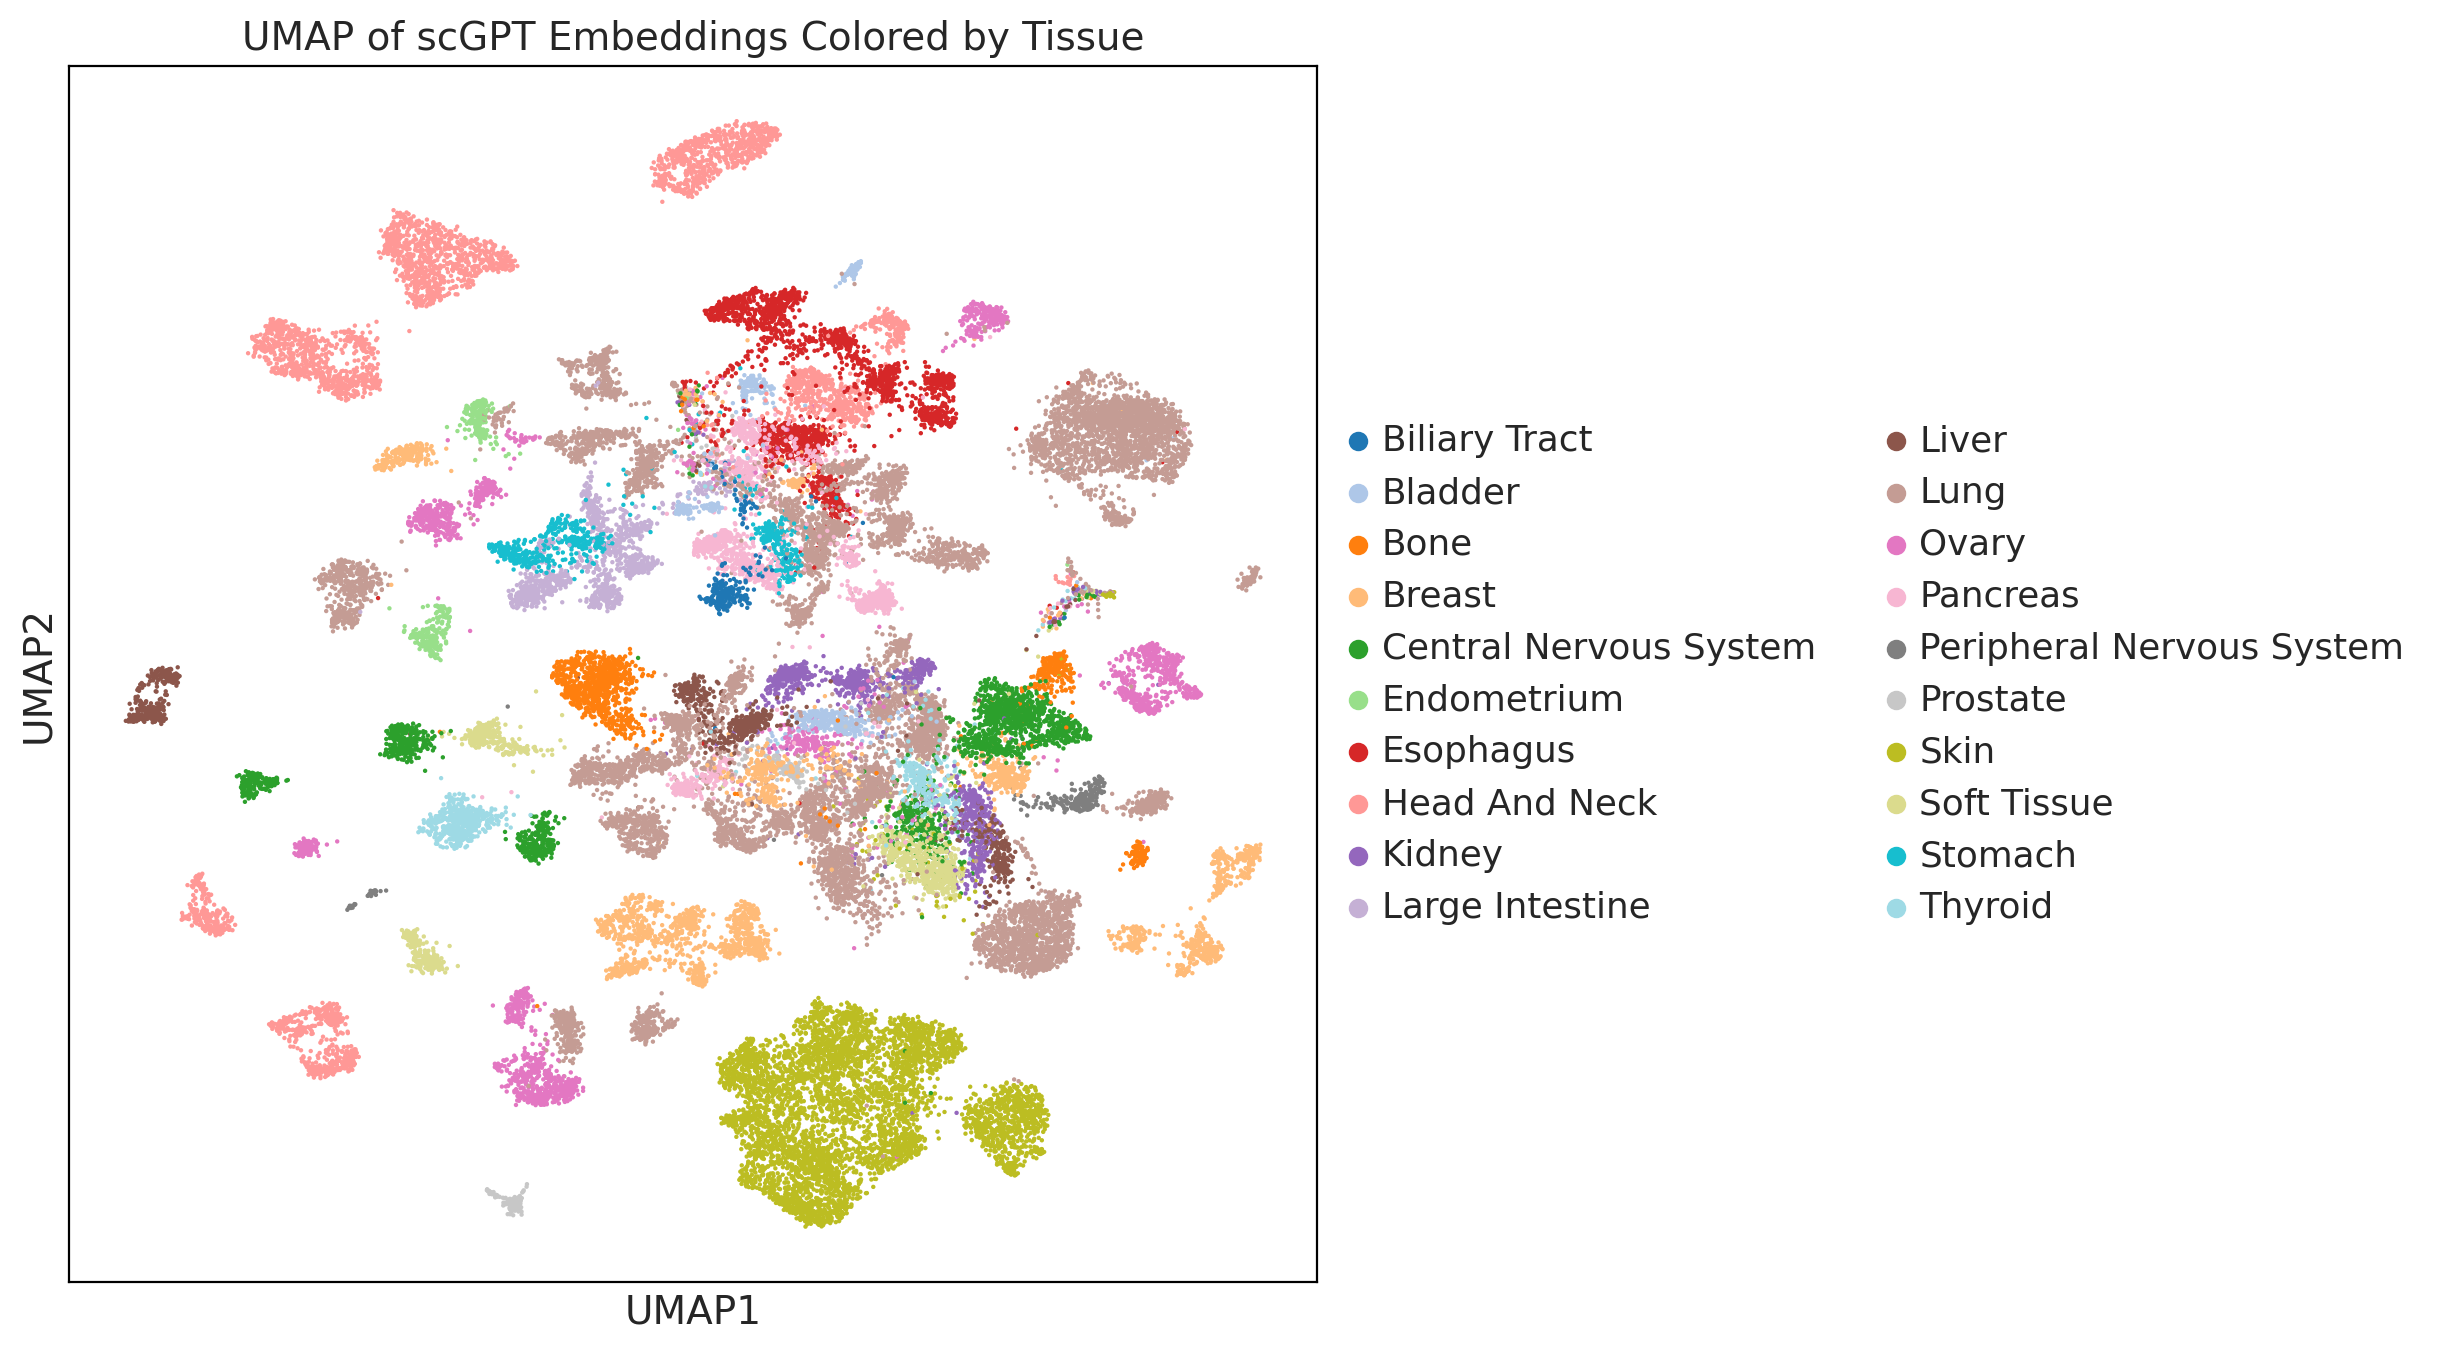

In [10]:
# 🧬 Construct AnnData object for UMAP
adata_emb = sc.AnnData(X=X_emb)
adata_emb.obs["Tissue"] = metadata_df["Tissue"].values

# Compute neighbors and UMAP
sc.pp.neighbors(adata_emb, n_neighbors=15, use_rep="X")
sc.tl.umap(adata_emb)

# 🎨 UMAP plot
sc.pl.umap(
    adata_emb,
    color="Tissue",
    title="UMAP of scGPT Embeddings Colored by Tissue",
    legend_loc="right margin",
    frameon=True,
    size=10,
    palette="tab20"
)
